In [11]:
reset -f

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt 

import glob


from astropy.time import Time
from astropy.coordinates import get_body_barycentric
import astropy.units as u

In [13]:
torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Working on {device}")

Working on cpu


In [14]:
# Gravitational constant for the Sun 
#mu = np.power(0.01720209895, 2) #([AU]^3/[day]^2)
mu = 398600.4418 #([km]^3/[s]^2)

# Solve Kepler's equation for elliptic orbits using Newton-Raphson iterations
def solve_kepler(M, e, tol=1e-10, maxiter=10):
    E = M.copy()
    for _ in range(maxiter):
        f  = E - e * np.sin(E) - M
        fp = 1 - e * np.cos(E)
        dE = -f / fp
        E += dE
        if np.all(np.abs(dE) < tol):
            break
    return E

# Change SRF functions
def equinoctial_to_cartesian(equin_coord):  #(a, h, k, p, q, L) --> (r; v)
    
    e = np.sqrt(equin_coord[1]**2 + equin_coord[2]**2)
    omega_plus_Omega = np.arctan2(equin_coord[1], equin_coord[2])

    i = 2 * np.arctan(np.sqrt(equin_coord[3]**2 + equin_coord[4]**2))
    Omega = np.arctan2(equin_coord[3], equin_coord[4])

    M = equin_coord[5] - omega_plus_Omega
    M = np.mod(M, 2*np.pi)
    E = solve_kepler(M,e)
   
    nu = 2 * np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))

    # Perifocal position and velocity
    r_pqw = equin_coord[0] * (1 - e*np.cos(E))
    r_vec_pqw = r_pqw * np.array([np.cos(nu), np.sin(nu), 0])
    v_vec_pqw = np.sqrt(mu * equin_coord[0]) / r_pqw * np.array([-np.sin(E), np.sqrt(1 - e**2)*np.cos(E), 0])

    # Rotation matrices
    cos_Om = np.cos(Omega)
    sin_Om = np.sin(Omega)
    cos_w = np.cos(omega_plus_Omega - Omega)
    sin_w = np.sin(omega_plus_Omega - Omega)
    cos_i = np.cos(i)
    sin_i = np.sin(i)

    # Perifocal to ECI transformation matrix
    R = np.array([
        [cos_Om*cos_w - sin_Om*sin_w*cos_i, -cos_Om*sin_w - sin_Om*cos_w*cos_i, sin_Om*sin_i],
        [sin_Om*cos_w + cos_Om*sin_w*cos_i, -sin_Om*sin_w + cos_Om*cos_w*cos_i, -cos_Om*sin_i],
        [sin_w*sin_i,                        cos_w*sin_i,                       cos_i]
    ])

    # Convert to ECI
    r = R @ r_vec_pqw
    v = R @ v_vec_pqw

    return r, v
    
def equinoctial_to_obs(equin_coord, r_obs=np.zeros(3), v_obs=np.zeros(3)): # here r_obs and v_obs are the coordinates of the observatory

    # Equinoctial → Cartesian
    r_ast, v_ast = equinoctial_to_cartesian(equin_coord)
    
    # Topocentric vectors
    rho_vec = r_ast - r_obs
    v_rel   = v_ast - v_obs

    rho     = np.linalg.norm(rho_vec)
    hat_rho = rho_vec / rho
    rho_dot = hat_rho.dot(v_rel)

    # Compute hat_rho_dot
    rho_hat_dot = (v_rel - rho_dot*hat_rho) / rho

    # Angles
    alpha = np.arctan2(hat_rho[1], hat_rho[0])
    delta = np.arcsin(hat_rho[2])

    # Angular rates
    denom = np.power(hat_rho[0], 2) + np.power(hat_rho[1], 2)
    alpha_dot = (hat_rho[0]*rho_hat_dot[1] - hat_rho[1]*rho_hat_dot[0]) / denom
    delta_dot = rho_hat_dot[2] / np.cos(delta)

    return alpha, delta, alpha_dot, delta_dot, rho, rho_dot

In [15]:
'''  
                                                            !!!
    
    The data can grow in number CONSIDERABLY if one considers all the observations of one night and creates triplets by randomly selecting them in this way:
    following the chronological time of observation, after 3 of them have been achieved, one can combine randomly the observations happened
    after the 3rd one with the first ones (NOT EXCLUSIVE), thus creating triplets of observations relatively close in time.
    Repeating this procedure for all the nights is possible to end up with multiples entries from each night.
    
                                                            !!!
'''  

columns_input  = ['alpha','delta','alpha_dot','delta_dot']
columns_output = ['rho','rho_dot']

def load_observations(prefix, input_names = columns_input, output_names = columns_output):
    
    ar_files = sorted(glob.glob(f"/home/FGeroni/Università/PhD/Code/NN_CelestialMechanics/PINN_DiffCorrections/{'datas_orbfit'}/{prefix}_N*.ar_sample"))
    
    t_list, X_list, Y_list = [], [], []

    for ar in ar_files:
        # read attributable line
        df_in = pd.read_csv(ar, sep='=', header=None, skiprows=1, nrows=1, names=['tag','values'], engine='python')
        attrib = [float(x) for x in df_in.loc[0,'values'].split()]
        s_attrib = pd.Series(attrib, index=columns_input)

        # read first data row (rho, rho_dot)
        df_out = pd.read_csv(ar, comment='%', sep='\\s+', skiprows= 8, nrows = 1, names=['i','j','rho','rho_dot','cc','succ','chi','Jac','E_Sun','E_Earth','H'], engine='python')
        s_out = df_out.loc[0, columns_output]

        # read epoch from mov_sample
        mov = ar.replace('.ar_sample', '.mov_sample')
        df_t = pd.read_csv(mov, sep='=', header=None, skiprows=1, nrows=1, names=['tag','epoch_str'], engine='python')
        epoch = float(df_t.loc[0,'epoch_str'].split()[0])
        
        t_list.append(epoch)
        X_list.append(s_attrib.values)
        Y_list.append(s_out.values)

    t_list = np.array(t_list)
    X_list = np.array(X_list)
    Y_list = np.array(Y_list)

    return torch.tensor(t_list).to(device), torch.tensor(X_list).to(device), torch.tensor(Y_list).to(device)

In [16]:
#Characteristics quantities of the system
AU =  149597870.7 # km in Au
day = 60*60*24 # s in day
L_c = 3.844e5 # (km) mean orbital radius of the moon
T_c = np.sqrt(np.power(L_c, 3) / mu) # (seconds) orbital period of the moon (2.361e6 [s]) 
V_c = L_c / T_c # (km/s) characteristic velocity

t_0 = torch.tensor([57291.95817]).float().to(device) # t0 for 2015RN35 in [MJD] (2015-11-01T23:00:00.000Z)

# Functions for data normalization
def normalize(inputs, export_minmax): # from standard to [-1, 1]
    inputs_min = inputs.min(dim=0, keepdim=True).values
    inputs_max = inputs.max(dim=0, keepdim=True).values
    
    if export_minmax == True:
        return 2*(inputs - inputs_min) / (inputs_max - inputs_min + 1e-8) - 1, inputs_min, inputs_max
    else:
        return 2*(inputs - inputs_min) / (inputs_max - inputs_min + 1e-8) - 1

def denormalize(inputs, inputs_min, inputs_max): # from [-1, 1] to standard
    
    return ((inputs + 1)/2)*(inputs_max - inputs_min + 1e-8) + inputs_min

#funtion for data a-dimensionalization
def non_dimensionalise(x, t, y): # x = (alpha, delta, alpha_dot, delta_dot), t = t_obs, y = (rho, rho_dot)
    x_nodim = torch.empty_like(x)
    x_nodim[:, 0] = x[:, 0] # dimensionless      
    x_nodim[:, 1] = x[:, 1] # dimensionless               
    x_nodim[:, 2] = (x[:, 2] / day) * T_c # ([rad/AU] → [rad/s]) → dimensionless                   
    x_nodim[:, 3] = (x[:, 3] / day) * T_c # ([rad/AU] → [rad/s]) → dimensionless                              

    t_mjd = (t - t_0.item()) # [MJD]
    t_sec = t_mjd*day # [MJD] → [s]
    t_nodim = t_sec / T_c # [s] → dimensionless 
    
    t_nodim = t_nodim.view(-1, 1)

    y_nodim = torch.empty_like(y)
    
    y_nodim[:, 0] = (y[:, 0] * AU) / L_c # ([AU] → [km]) → dimensionless              
    y_nodim[:, 1] = (y[:, 1] * (AU/day)) / V_c  # ([AU/day] → [km/s]) → dimensionless  
    
    return x_nodim, t_nodim, y_nodim

In [17]:
class FourierEmbedding(nn.Module):
    def __init__(self, in_dim, mapping_size, scale):
        super().__init__()
        self.register_buffer('B', torch.randn(in_dim, mapping_size) * scale)

    def forward(self, x):
        B = self.B.to(x.device).to(x.dtype)
        x_proj = 2 * np.pi * x @ B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [ ]:
#-------------------- Core class : Physics-Informed Neural Network for Very Short Arcs -------------------------------------------------------
class PINN_VSA(nn.Module):
    
    def __init__(self, layers, loss_type, n_batch, mu, t0_mjd, t_edges, *data, fourier_m = 8, fourier_scale = 2.0): 
        super(PINN_VSA, self).__init__() 

        self.fourier = FourierEmbedding(in_dim=5, mapping_size=fourier_m, scale=fourier_scale)

        L0 = 2 * fourier_m # size on input layer is bigger using fourier embedding
        layers = [L0] + layers[1:]
        self.mu = mu

        #---------------------------------------- Data Loader --------------------------------------------
        (t0, x0, y0, t_domain, x_domain, y_domain) = data
        self.n_batch = n_batch
        self.losstype = loss_type

        n_data = len(t_domain)
        part = 3/5 # 60% of the data for training, 40% for validation
        n_train = max(1, int(part * n_data))
        
        self.train_dataset = TensorDataset(x_domain[0:n_train], t_domain[0:n_train], y_domain[0:n_train])
        self.train_loader = DataLoader(self.train_dataset, batch_size=n_batch, shuffle=True)

        self.ic_dataset = TensorDataset(x0, t0, y0)
        self.ic_loader = DataLoader(self.ic_dataset, batch_size=n_batch, shuffle=True)
        
        self.x_valid = x_domain[n_train:] 
        self.t_valid = t_domain[n_train:]
        self.y_valid = y_domain[n_train:]

        self.valid_dataset = TensorDataset(self.x_valid, self.t_valid, self.y_valid)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size=n_batch, shuffle=True)
        
        self.t0_mjd = t0_mjd # MJD of the first observation, used in "get_earth_position"

        self.t_edges = t_edges # edges of the time domain, used in "get_earth_position"

        #---------------------------------------- Define layers ------------------------------------------
        self.layers = nn.ModuleList()
        self.activation = nn.Tanh() # Activation function
        
        self.s_list = {}
        self.v_list = {}
        biases = []
        mean = 1.0
        std = 0.1
        
        for i in range(len(layers) - 1): 
            
            self.layers.append(nn.Linear(layers[i], layers[i+1], bias = True)) # Fully connected linear layer: the operation [out = w*input + b] will be made by hand with factorized weights
            
            # Random weight factorization memorization
            W = self.layers[-1].weight.detach().clone()  # weights are bot trained but used only now to calculate their factorization
            
            s = torch.exp(torch.randn(layers[i+1])*std + mean)
            v = W / s.unsqueeze(1)

            self.s_list[f"s_{i}"] = nn.Parameter(s, requires_grad = True)
            self.register_parameter(f"s_{i}", self.s_list[f"s_{i}"])  # Register the parameter
            
            self.v_list[f"v_{i}"] = nn.Parameter(v, requires_grad = True)
            self.register_parameter(f"v_{i}", self.v_list[f"v_{i}"]) # Register the parameter
            
            biases.append(self.layers[-1].bias.requires_grad_(True))

            self.layers[i].weight.requires_grad_(False) # we don't need to train these
            self.layers[i].bias.requires_grad_(False) # we have copied the trainable ones in the list "biases" 
            
        self.new_param = list(self.s_list.values()) + list(self.v_list.values()) + biases # new parameters to be trained
        
        #----------------------------------------------------------------------------------------------------------------------------
        self.optimizer = None
        self.train_loss_history = []
        
        #------------------------ For weighted loss procedures and temporal weights -------------------------------------------------
        self.n_losses = 5 # Number of losses: IC, PDE, residual, interstellar orbits, surface revolution
        self.loss_weights = torch.ones(self.n_losses, device = device).requires_grad_(False) # Initialize losses weights
        self.f = 50
        self.alpha = 0.9
        self.epsilon = 1.0
        

    # ------------------------------ Core functions of the PINN_VSA class --------------------------------------------
    def get_factorized_weight(self, i):        
        b = self.layers[i].bias

        s = self.s_list[f"s_{i}"]
        v = self.v_list[f"v_{i}"]
        
        return (s.view(-1,1) * v), b
    
        
    def forward(self, X): # Forward pass using random decomposed weights
        X_embed = self.fourier(X)
        a = X_embed.float()
        
        for i in range(len(self.layers) - 1):
            input_copy = a # for skip connections
            
            kernel, b = self.get_factorized_weight(i)
            a = a @ kernel.T + b 
            
            if i < (len(self.layers) - 1):
                a = self.activation(a)

                #Skip connections are activated only after the input layer
                if i >= 1: 
                    if a.shape != input_copy.shape: #In case of layers of different size make the input_copy compatible with the output
                        input_copy = torch.matmul(input_copy, torch.eye(input_copy.shape[1], a.shape[1], device=a.device)) # 
                    a = a + input_copy
                     
        kernel, b = self.get_factorized_weight(len(self.layers)-1)
        a = a @ kernel.T + b 
                    
        return a 

    
    def network_prediction(self, t, x):

        return self.forward(torch.cat([t, x], 1))


    # ----------------------------- Helper functions for the PINN_VSA class --------------------------------------------
    def log_cosh(self, x): # Numerically stable logcosh

        return x + torch.nn.functional.softplus(-2.0 * x) - np.log(2.0)


    def get_derivative(self, y, x, n): # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:  # (n is the order if the derivative)
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(device), retain_graph=True, allow_unused=True, create_graph=True)[0]
            if dy_dx is None:
                return None
        return self.get_derivative(dy_dx, x, n - 1)

    
    def get_earth_position(self, t): # Get the heliocentric position of the Earth respect to the Sun at time t
        t_nodim = denormalize(t, self.t_edges[0], self.t_edges[1])

        t_seconds = t_nodim * T_c # [dimensionless] → [s]
        t_days = t_seconds / day # [s] → [days]
        t_mjd = t_days + self.t0_mjd.item() # [days] → [MJD]
        t_mjd = t_mjd.detach().cpu().numpy()
                
        times = Time(t_mjd, format='mjd')
        earth_cart = get_body_barycentric('earth', times) 

        xyz_au = u.Quantity(
            [earth_cart.x.to_value(u.au),
             earth_cart.y.to_value(u.au),
             earth_cart.z.to_value(u.au)],
            unit=u.au
        ).T 
        
        xyz = torch.from_numpy(xyz_au.value).to(torch.float32).to(device)
        
        return xyz

	       
    def attributable_to_cartesian(self, att): # (alpha, delta, alpha_dot, delta_dot, rho, rho_dot) --> (r, v)
        # unit line-of-sight
        cd, sd = torch.cos(att[:,1]), torch.sin(att[:,1])
        ca, sa = torch.cos(att[:,0]), torch.sin(att[:,0])
        rho_hat =  torch.stack([cd*ca, cd*sa, sd], dim=1)

        # partials
        d_rho_hat_dalpha = torch.stack([-cd*sa, cd*ca, torch.zeros_like(sd)], dim=1)
        d_rho_hat_ddelta = torch.stack([-sd*ca, -sd*sa, cd], dim=1)

        # time-derivative of rho_hat
        rho_hat_dot = d_rho_hat_dalpha * att[:,2].unsqueeze(1) + d_rho_hat_ddelta * att[:,3].unsqueeze(1)

        # position and velocity
        r = att[:,4].unsqueeze(1) * rho_hat
        v = att[:,5].unsqueeze(1) * rho_hat + att[:,4].unsqueeze(1) * rho_hat_dot

        r.requires_grad_(True).float().to(device)
        v.requires_grad_(True).float().to(device)
        
        return r, v


    # ------------------------ Loss functions for the PINN_VSA class --------------------------------------------
    def surface_revolution(self, t, x): # Compute the surface revolution around the line Sun-Earth
        out = self.network_prediction(t, x)

        v_a =  torch.cat([x, out], dim=1)
        
        r, v = self.attributable_to_cartesian(v_a)
            
        r_earth = self.get_earth_position(t) # Get the Earth position at time t
        r_earth = (r_earth * AU) / L_c
        r_earth = normalize(r_earth, None)

        r_ast = r - r_earth
        
        f = v_a[:,4].unsqueeze(1).pow(2) - r_ast.norm(dim=1, keepdim=True).pow(2) - \
            (2 * r_earth.norm(dim=1, keepdim=True).pow(5))/(3 * r_ast.norm(dim=1, keepdim=True).pow(3)) \
                + (5/3)*r_earth.norm(dim=1, keepdim=True).pow(2)
        
        return f
    
    
    def loss_interstellar(self, t, x):
        out = self.network_prediction(t, x)
        att = torch.cat([x, out], dim=1)
        r, v = self.attributable_to_cartesian(att)  # heliocentric position and velocity

        v2 = (torch.pow(v,2)).sum(dim=1)
        rnorm = r.norm(dim=1)

        E = 0.5 * v2 - self.mu / (rnorm + 1e-8)

        # Penalize only positive energy (satellite of the Sun)
        penalty_interstellar = torch.relu(E)

        return penalty_interstellar.mean()* 1000.0 # enforcing the penalty

    
    def energy_conservation(self, t, x): # Compute the specific orbital energy variation in time
        out = self.network_prediction(t, x) # (rho, rho_dot)
        
        att = torch.cat([x, out], dim=1)
        r, v = self.attributable_to_cartesian(att)
        
        dv_dt = self.get_derivative(v, t, 1).float().to(device)
        
        if dv_dt == None:
            dv_dt = torch.zeros_like(v).requires_grad_(True).float().to(device)
                    
        vr = (v * dv_dt).sum(dim=1)
        rv = (r * v).sum(dim=1)
        rnorm3 = torch.pow(r.norm(dim=1), 3)
            
        dE_dt =  vr - self.mu * ( rv / (rnorm3 + 1e-8) ) # v·dv_dt =  mu(r·v/(|r|^(3)))
        
        return dE_dt


    def ang_mom_conservation(self, t, x):
        out = self.network_prediction(t, x)  # (rho, rho_dot)
        att = torch.cat([x, out], dim=1)
        r, v = self.attributable_to_cartesian(att) 

        # Compute angular momentum vector L = r x v
        L = torch.cross(r, v, dim=1) 

        dL_dt = self.get_derivative(L, t, 1)
        if dL_dt is None:
            dL_dt = torch.zeros_like(L).requires_grad_(True).float().to(device)

        return dL_dt

    ''' CORRECTED VERSION OF THE ENERGY AND ANGULAR MOMENTUM CONSERVATION FUNCTIONS
        def energy_conservation(self, t, x): # Compute the specific orbital energy variation in time
        out = self.network_prediction(t, x) # (rho, rho_dot)
        
        x = denormalize(x, self.x_border[0], self.x_border[1])  # Denormalize x to original scale
        t_denorm = denormalize(t, self.t_border[0], self.t_border[1])  # Denormalize time to original scale
        out = denormalize(out, self.y_border[0], self.y_border[1])  # Denormalize output to original scale
        
        att = torch.cat([x, out], dim=1)
        
        # Get geocentric coordinates and convert to heliocentric
        r_geocentric, v_geocentric = self.attributable_to_cartesian(att)
        r, v = self.geocentric_to_heliocentric(r_geocentric, v_geocentric, t)

        dv_dt = self.get_derivative(v, t_denorm, 1)  # Should be (batch_size, 3)

        if dv_dt is None:
            dv_dt = torch.zeros_like(v, dtype=torch.float32, device=device).requires_grad_(True)
                    
        vr = (v * dv_dt).sum(dim=1)
        rv = (r * v).sum(dim=1)
        rnorm3 = torch.pow(r.norm(dim=1), 3)
        
        # Use dimensionless μ for consistency (use km-based μ)
        dE_dt = vr - mu_dimensionless * (rv / (rnorm3 + 1e-8)) # v·dv_dt = mu(r·v/(|r|^(3)))
        
        return dE_dt


    def ang_mom_conservation(self, t, x):
        out = self.network_prediction(t, x)  # (rho, rho_dot)

        x = denormalize(x, self.x_border[0], self.x_border[1])  # Denormalize x to original scale
        t_denorm = denormalize(t, self.t_border[0], self.t_border[1])  # Denormalize time to original scale
        out = denormalize(out, self.y_border[0], self.y_border[1])  # Denormalize output to original scale
        
        att = torch.cat([x, out], dim=1)
        
        # Get geocentric coordinates and convert to heliocentric
        r_geocentric, v_geocentric = self.attributable_to_cartesian(att)
        r, v = self.geocentric_to_heliocentric(r_geocentric, v_geocentric, t)

        # Compute angular momentum vector L = r x v in heliocentric frame
        L = torch.cross(r, v, dim=1) 

        dL_dt = self.get_derivative(L, t_denorm, 1)
        if dL_dt is None:
            dL_dt = torch.zeros_like(L).requires_grad_(True).float().to(device)

        return dL_dt
    '''

    def loss_IC(self, x, t, y):
        y_pred_IC = self.network_prediction(t, x)
        if self.losstype == 'mse':
            loss_IC = torch.mean(torch.pow((y - y_pred_IC),2))
        elif self.losstype == 'logcosh':
            loss_IC = torch.mean(self.log_cosh(y - y_pred_IC))
        return loss_IC

    def loss_residual(self, x, t, y):
        y_pred = self.network_prediction(t, x)
        if self.losstype == 'mse':
            loss_residual = torch.mean(torch.pow((y - y_pred),2))
        elif self.losstype == 'logcosh':
            loss_residual = torch.mean(self.log_cosh(y - y_pred))
        return loss_residual

    def loss_surface_revolution(self, t, x):
        f_pred = self.surface_revolution(t, x)
        if self.losstype == 'mse':
            loss_sr = torch.mean(torch.pow(f_pred,2))
        elif self.losstype == 'logcosh':
            loss_sr = torch.mean(self.log_cosh(f_pred))
        return loss_sr

    def loss_PDE(self, x, t):
        dE_dt = self.energy_conservation(t, x)
        dL_dt = self.ang_mom_conservation(t, x)
        if self.losstype == 'mse':
            loss_PDE = torch.mean(torch.pow(dE_dt,2))
            loss_PDE += torch.mean(torch.pow(dL_dt,2))
        elif self.losstype == 'logcosh':
            loss_PDE = torch.mean(self.log_cosh(dE_dt))
            loss_PDE += torch.mean(self.log_cosh(dL_dt))
        return loss_PDE

    '''
    def forward_temp_weights(self, loss_domain):
        loss_domain = torch.tensor(loss_domain, device=self.temporal_weights.device)
        
        self.temporal_weights = torch.exp(-self.epsilon * torch.cumsum(loss_domain, dim=0))
    '''

    # --------------------------------------------------------------------------------------------------------

    def forward_loss_weights(self, losses):       
        parameters = [p for p in self.new_param if p.requires_grad and p.is_leaf] # pick only the parameters that we actually want to differentiate
        
        # Create the gradient of each component of the loss respect to the parameters of the model
        grad_norms = []
        
        for l in losses: 
            l = l.clone().detach().requires_grad_(True) # make sure this loss is tracked in the current graph
            
            grads = torch.autograd.grad(l, parameters, retain_graph = True, create_graph=True, allow_unused=True)

            flat = []
            for g in grads:
                if g is not None:
                    flat.append(g.view(-1))
            if flat:
                grad_norms.append(torch.norm(torch.cat(flat)))
            else:
                grad_norms.append(torch.tensor(0.0, device=l.device))
            
        grad_norms = torch.stack(grad_norms)

        # Update loss weights
        lambda_hat = grad_norms.sum() / (grad_norms + 1e-8) # ensure lambda is not infinite
        
        self.loss_weights = self.alpha*self.loss_weights.clone() + (1 - self.alpha)*lambda_hat
        
    
    def get_training_history(self):
        loss_his = np.array(self.train_loss_history)
        total_loss, loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution, loss_validation = np.split(loss_his, 7, axis=1) 
        
        return total_loss, loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution, loss_validation


    # ---------------------------------------------- Training routine ---------------------------------------------------
    def train_network(self, epochs, learning_rate, regularization):
        optim = 'AdamW'
        self.optimizer = torch.optim.AdamW(self.new_param, lr = learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=regularization, amsgrad=True)
        #self.optimizer = torch.optim.Adam(self.new_param, lr = learning_rate, weight_decay = regularization, amsgrad=True) 

        # Learning-rate warmp-up + exponential decay scheduler
        warmup_steps = 600

        warmup_lr = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda = lambda step: min(1.0, (step+1) / warmup_steps)) # lr_Lambda for warmup: lr(t) = [(t / warmup_steps) for t ≤ warmup_steps; 1 afterwards]
        decay_lr = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 2000, gamma = 0.90) # exponential decay every step_size steps by factor gamma
        self.scheduler = torch.optim.lr_scheduler.ChainedScheduler([warmup_lr, decay_lr])

        # Validation training checkpoint 
        self.best_val_loss = float('inf')
        self.best_val_model_state = None

        # Training loop
        for epoch in range(epochs):
            loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution, loss_validation = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

            self.optimizer.zero_grad()
            
            # Mini-batch loss for Initial Conditions (IC) 
            for ic_batch_idx, batch in enumerate(self.ic_loader, 1):
                batch_x0, batch_t0, batch_y0 = [b.to(device) for b in batch]
                
                loss_IC += self.loss_IC(batch_x0, batch_t0, batch_y0)
            
            if ic_batch_idx != 0: # average the loss over the number of batches
                loss_IC /= ic_batch_idx

            # Mini-batch loss for Domain and Physical constraints (PDEs) 
            for train_batch_idx, batch in enumerate(self.train_loader, 1):
                batch_x_domain, batch_t_domain, batch_y_domain = [b.to(device) for b in batch]
                batch_t_domain.requires_grad_(True)  # <-- Ensure autograd for PINN loss

                loss_PDE += self.loss_PDE(batch_x_domain, batch_t_domain)   
                loss_residual += self.loss_residual(batch_x_domain, batch_t_domain, batch_y_domain)
                loss_interstellar += self.loss_interstellar(batch_t_domain, batch_x_domain)
                loss_surface_revolution += self.loss_surface_revolution(batch_t_domain, batch_x_domain)
            
            if train_batch_idx != 0: # average the loss over the number of batches
                loss_PDE /= train_batch_idx
                loss_residual /= train_batch_idx
                loss_interstellar /= train_batch_idx
                loss_surface_revolution /= train_batch_idx

                        # Mini-batch loss for validation (IC not relevant here)
            for valid_batch_idx, batch in enumerate(self.valid_loader, 1):
                batch_x_valid, batch_t_valid, batch_y_valid = [b.to(device) for b in batch]
                batch_t_valid.requires_grad_(True)  # <-- Ensure autograd for PINN loss

                loss_validation += self.loss_PDE(batch_x_valid, batch_t_valid)   
                loss_validation += self.loss_residual(batch_x_valid, batch_t_valid, batch_y_valid)
                loss_validation += self.loss_interstellar(batch_t_valid, batch_x_valid)
                loss_validation += self.loss_surface_revolution(batch_t_valid, batch_x_valid)
            
            if valid_batch_idx != 0: # average the loss over the number of batches
                loss_validation /= valid_batch_idx

            # Give a weights to every singular loss term
            weighted_losses = self.loss_weights.clone()*torch.stack([loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution]) # [loss_IC, loss_PDE, loss_residual, loss_surface_revolution]
            
            # Total loss for this epoch after having given the weights
            total_loss = weighted_losses.sum()

            '''
            torch.autograd.set_detect_anomaly(True) # DEBUG
            '''
            # Save losses for the current epoch
            self.train_loss_history.append([total_loss.cpu().detach(), weighted_losses[0].cpu().detach(), weighted_losses[1].cpu().detach(), weighted_losses[2].cpu().detach(), weighted_losses[3].cpu().detach(), weighted_losses[4].cpu().detach(), loss_validation.cpu().detach()]) # save the losses for the current epoch
            
            total_loss.backward() # retain_graph=False for efficiency
            
            if epoch % self.f == 0:
                # Calculate gradients and retain graph in order to derive also all of the singular losses terms for the correspondant global weigth
                self.forward_loss_weights([loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution]) # global weights update routine using the non-weigthed losses

            # Clip gradients to avoid exploding gradients    
            torch.nn.utils.clip_grad_norm_(self.new_param, max_norm=1.0) # clipping
            
            # Optimize the network parameters            
            self.optimizer.step()
            
            self.scheduler.step()

            # Validation loss monitoring and checkpointing 
            if loss_validation.detach().cpu().numpy() < self.best_val_loss:
                self.best_val_loss = loss_validation.detach().cpu().numpy()
                self.best_val_model_state = {'model': self.state_dict(), 'epoch': epoch}
            
            # Print out the loss every 100 epochs
            if epoch % 500 == 0:
                print(f'Epoch: {epoch}; Total loss: {total_loss.detach().cpu().numpy():.4e}; Valid. loss: {loss_validation.detach().cpu().numpy():.4e}')

        # Restore best validation model
        if self.best_val_model_state is not None:
            print(f"Restoring best model from epoch {self.best_val_model_state['epoch']} with val loss {self.best_val_loss:.4e}")
            self.load_state_dict(self.best_val_model_state['model'])

In [19]:
# Data importing and handling
t_allN, x_allN, y_true_allN = load_observations('2015RN35')

'''
# Shuffle !
idx = torch.randperm(len(t_allN))

x_allN = x_allN[idx]
t_allN = t_allN[idx]
y_true_allN = y_true_allN[idx]
'''

# Import initial conditions from fitob
Input_0_equin = np.array([1.4597513976025835, 0.285859684022060, 0.187526292392717, -0.001113623441851, -0.001969823345975, 34.9412629996062])  # from .eq0 orbfit file
Input_0_cart = np.array([equinoctial_to_obs(Input_0_equin)])
Input_0 = torch.tensor(Input_0_cart).float().to(device)

x_0 = Input_0[:,0:4] # (alpha_0, delta_0, alpha_0_dot, delta_0_dot)
y_0_true = Input_0[:,4:6] # (rho_0, rho_0_dot)

# A-dimensionalization
x_allN, t_allN, y_true_allN = non_dimensionalise(x_allN, t_allN, y_true_allN)
x0, t0, y0_true = non_dimensionalise(x_0, t_0, y_0_true)

# Normalization (optional)
t_allN, t_mins, t_maxs  = normalize(t_allN, True)
x_allN, x_mins, x_maxs  = normalize(x_allN, True)
y_true_allN, y_mins, y_maxs = normalize(y_true_allN, True)

t0 = normalize(t0, None)
x0 = normalize(x0, None)
y0_true = normalize(y0_true, None)

In [20]:
layers = [5, 64, 64, 64, 64, 2] # input features [(x, t) = 5, con Fourier diventano 2*fourier_m] | hidden layers | outputs (y)

losstype = 'mse' # 'mse' or 'logcosh'
n_batch = 4 # Batch size for training
epochs = 5000 # Number of epochs for training
L_rate = 0.001 # Learning rate 
lambda_reg = L_rate * 1.0 # Regularization parameter for AdamW

model = PINN_VSA(layers, losstype, n_batch, mu, t_0, [t_mins, t_maxs], t0, x0, y0_true, t_allN, x_allN, y_true_allN).to(device) # AdamW 

model.train_network(epochs, L_rate, lambda_reg)

Epoch: 0; Total loss: 1.9595e+13; Valid. loss: 1.0397e+14
Epoch: 500; Total loss: 6.6111e+04; Valid. loss: 1.3504e+07
Epoch: 500; Total loss: 6.6111e+04; Valid. loss: 1.3504e+07
Epoch: 1000; Total loss: 2.8573e+03; Valid. loss: 8.1748e+05
Epoch: 1000; Total loss: 2.8573e+03; Valid. loss: 8.1748e+05
Epoch: 1500; Total loss: 7.3707e+02; Valid. loss: 1.4396e+06
Epoch: 1500; Total loss: 7.3707e+02; Valid. loss: 1.4396e+06
Epoch: 2000; Total loss: 1.8706e+02; Valid. loss: 9.6112e+05
Epoch: 2000; Total loss: 1.8706e+02; Valid. loss: 9.6112e+05
Epoch: 2500; Total loss: 3.3045e+01; Valid. loss: 2.5577e+05
Epoch: 2500; Total loss: 3.3045e+01; Valid. loss: 2.5577e+05
Epoch: 3000; Total loss: 1.4291e+01; Valid. loss: 1.1727e+05
Epoch: 3000; Total loss: 1.4291e+01; Valid. loss: 1.1727e+05
Epoch: 3500; Total loss: 3.1010e+00; Valid. loss: 6.7550e+04
Epoch: 3500; Total loss: 3.1010e+00; Valid. loss: 6.7550e+04
Epoch: 4000; Total loss: 7.4842e-01; Valid. loss: 3.7423e+04
Epoch: 4000; Total loss: 7.48

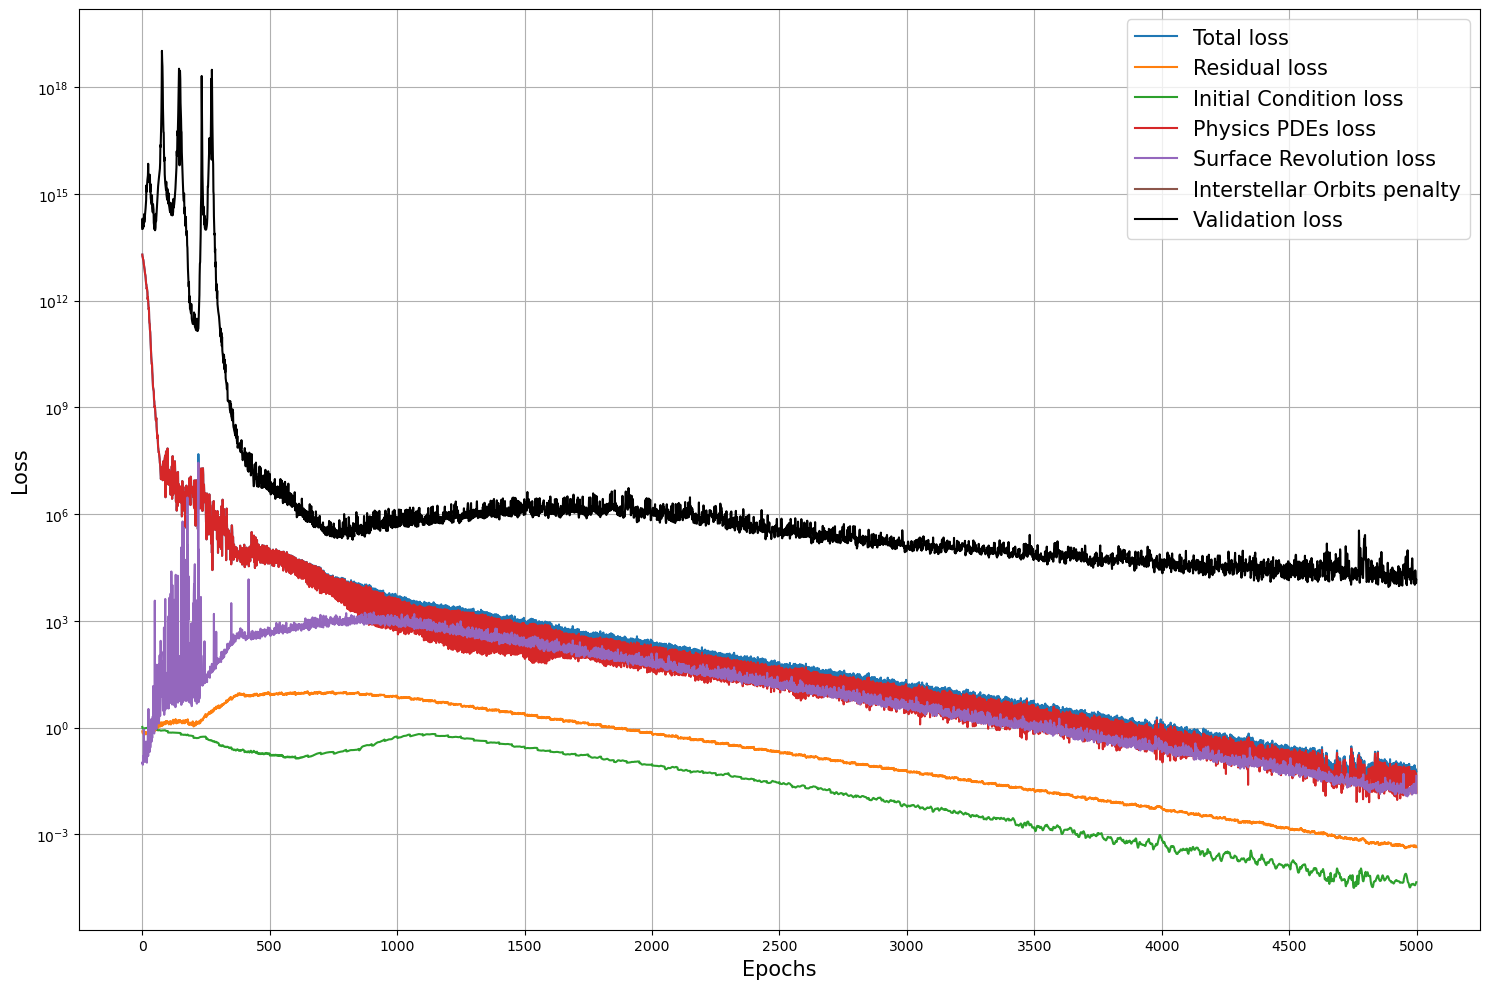

In [24]:
total_loss, loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution, loss_validation = model.get_training_history() 

plt.figure(figsize=(15, 10))
plt.plot(total_loss, label='Total loss')
plt.plot(loss_residual, label='Residual loss')
plt.plot(loss_IC, label='Initial Condition loss')
plt.plot(loss_PDE, label='Physics PDEs loss')
plt.plot(loss_surface_revolution, label='Surface Revolution loss')
plt.plot(loss_interstellar, label='Interstellar Orbits penalty')
plt.plot(loss_validation, label='Validation loss', color='black', linewidth=1.5, alpha=1.0)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.yscale('log')
plt.xscale('linear')
plt.xticks(np.arange(0, epochs+1, epochs//10))
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Get model predictions after training
y_pred = model.network_prediction(model.t_valid, model.x_valid).detach().cpu()

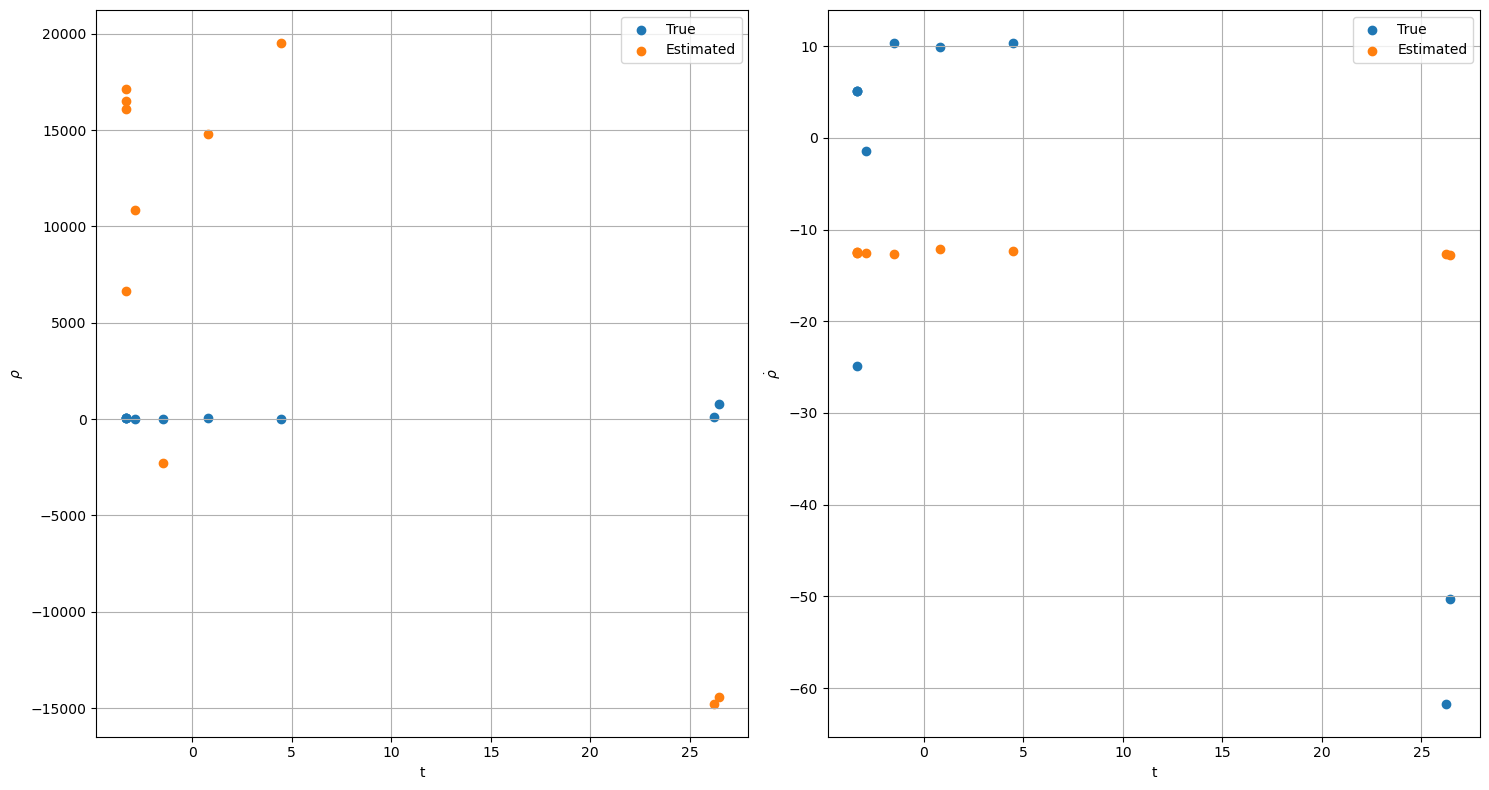

In [23]:
t_valid = denormalize(model.t_valid, t_mins, t_maxs)
x_valid = denormalize(model.x_valid, x_mins, x_maxs)
y_valid = denormalize(model.y_valid, y_mins, y_maxs)
y_pred = denormalize(y_pred, y_mins, y_maxs)

t_valid = t_valid.detach().cpu().numpy()
x_valid = x_valid.detach().cpu().numpy()
y_valid = y_valid.detach().cpu().numpy()
y_pred = y_pred.numpy()

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].scatter(t_valid, y_valid[:,0], label = 'True')
axes[0].scatter(t_valid, y_pred[:,0], label = 'Estimated')
axes[0].set_xlabel('t')
axes[0].set_ylabel(r'$\rho$')
axes[0].legend()
axes[0].grid(True)


axes[1].scatter(t_valid, y_valid[:,1], label = 'True')
axes[1].scatter(t_valid, y_pred[:,1], label = 'Estimated')
axes[1].set_xlabel('t')
axes[1].set_ylabel(r'$\dot{\rho}$')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()